In [1]:
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from faker import Faker
from faker.providers import BaseProvider

import random as rng
from copy import deepcopy

from commons import remove_symbols, extract_symbols, get_coordinates
from collections import Counter

<h2> Skills </h2>
Come prima parte della generazione dei dati, è necessario specificare quali siano le possibili skill che un developer possa avere.


In [2]:
with sqlite3.connect('../datasets/skills_dataset.db') as skills_conn:
    skills_frame = pd.read_sql('SELECT * FROM Skills', skills_conn, index_col='ID') 
skills_frame

,SKILL,TYPE
ID,,
0,JavaScript,Programming Language
1,HTML,Programming Language
2,Python,Programming Language
4,TypeScript,Programming Language
5,Bash,Programming Language
...,...,...
100,Git,Tool
101,Travis,Tool
102,Swift,Programming Language


<h2> Generazione dei profili</h2>
<p> Si passa quindi ad usare un LLM per la generazione dei dati, in particolare GPT 3.5 Turbo</p>
<p> La generazione si svolge in questo modo</p>
<ul>
    <li> Generazione dei linguaggi di programmazione. </li>
    <li> Generazione dei framework. </li>
    <li> Generazione dei dei database conosciuti. </li>
    <li> Generazione dei tools conosciuti. </li>
    <li> Generazione delle piattaforme cloud. </li>
</ul>

<p> Sono state generate 509 tuple. </p>

In [3]:
gpt_generated_frame = pd.read_csv('../datasets/new_gpt_generated_dataset.csv', index_col='ID')

gpt_generated_frame

,Linguaggi di Programmazione,Framework,Database,Tools,Cloud
ID,,,,,
1,"HTML,CSS,JavaScript","React,Angular,Vue.js","MySQL,Oracle","npm,Webpack,Visual Studio",Heroku
2,"Python,JavaScript","Django,Flask,NumPy","MongoDB,MySQL","Pip,Homebrew,Composer",AWS
3,"TypeScript,JavaScript,CSS","React,Angular,Vue.js","PostgreSQL,MySQL","Yarn,Webpack,CMake",Google Cloud
4,"Bash,Python","NumPy,PyTorch,Scikit-Learn","MongoDB,Redis","Docker,Pacman,Homebrew",Docker
5,"Java,C++,HTML,CSS,JavaScript","Spring,JavaEE,React,Angular,Vue.js","MySQL,Oracle,Microsoft SQL Server","Maven,Gradle,Kubernetes",Azure
...,...,...,...,...,...
504,"CSS,JavaScript,HTML","React,Angular,Vue.js","MySQL,PostgreSQL","npm,Webpack,Visual Studio",Vercel
505,"HTML,CSS,JavaScript","React,Angular,Vue.js","MySQL,Redis","npm,Webpack,Visual Studio",Netlify
506,"Python,JavaScript,CSS","Django,Flask,NumPy","MongoDB,MySQL","Pip,Homebrew,Composer",AWS


## Pre-Processing dei Dati
Il dataset corrente verrà ristrutturato in modo da avere una rappresentazione omologa a quella presente nel dataset delle offerte, filtrando, al contempo, le skill generate non presenti nel dataset delle skills in uso

In [4]:
gpt_generated_frame.rename(columns={
    'Linguaggi di Programmazione': 'progLang',
    'Framework' : 'framework',
    'Database' : 'database',
    'Tools' : 'tools',
    'Cloud' : 'cloud'}, inplace= True)

developer_frame = pd.DataFrame(columns=['name', 'surname', 'email', 'password', 'bio', 'location', 'lon', 'lat', 'languages', 'skills'])
skills: list[set[str]] = []

skills_list = [skill.lower() for skill in skills_frame['SKILL'].tolist()]
for row in gpt_generated_frame.itertuples():
    raw_skill_set = f'{row.progLang} {row.framework} {row.database} {row.tools} {row.cloud}'
    
    sset = extract_symbols(
        remove_symbols(raw_skill_set),
        list(skills_list)
    )
    skills.append(sset)

developer_frame['skills'] = skills

developer_frame

,name,surname,email,password,bio,location,lon,lat,languages,skills
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{angular, react, mysql, webpack, css, vue .js,..."
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{composer, django, python, flask, mysql, mongo..."
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{typescript, angular, yarn, react, google clou..."
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{redis, python, numpy, pytorch, mongodb, pacma..."
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{angular, react, gradle, mysql, maven, java, c..."
...,...,...,...,...,...,...,...,...,...,...
504,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{angular, react, mysql, vercel, webpack, css, ..."
505,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{angular, redis, react, mysql, netlify, webpac..."
506,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{composer, django, python, flask, mysql, css, ..."
507,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{typescript, angular, yarn, react, mysql, webp..."


<h2> Esplorazione dei dati Generati </h2>
<p> Si passa ora all'esplorazione dei dati generati. <br> 
Questo avverrà mediante la realizzazione di un barplot circa la frequenza delle skill che compaiono nel dataset, oltre che un boxplot che misuri il numero di skill che compaiono per profilo. <br>
</p>

C:\Users\anton\AppData\Local\Temp\ipykernel_22740\4258322119.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_counts.values(), y=sorted_counts.keys(), palette='viridis')


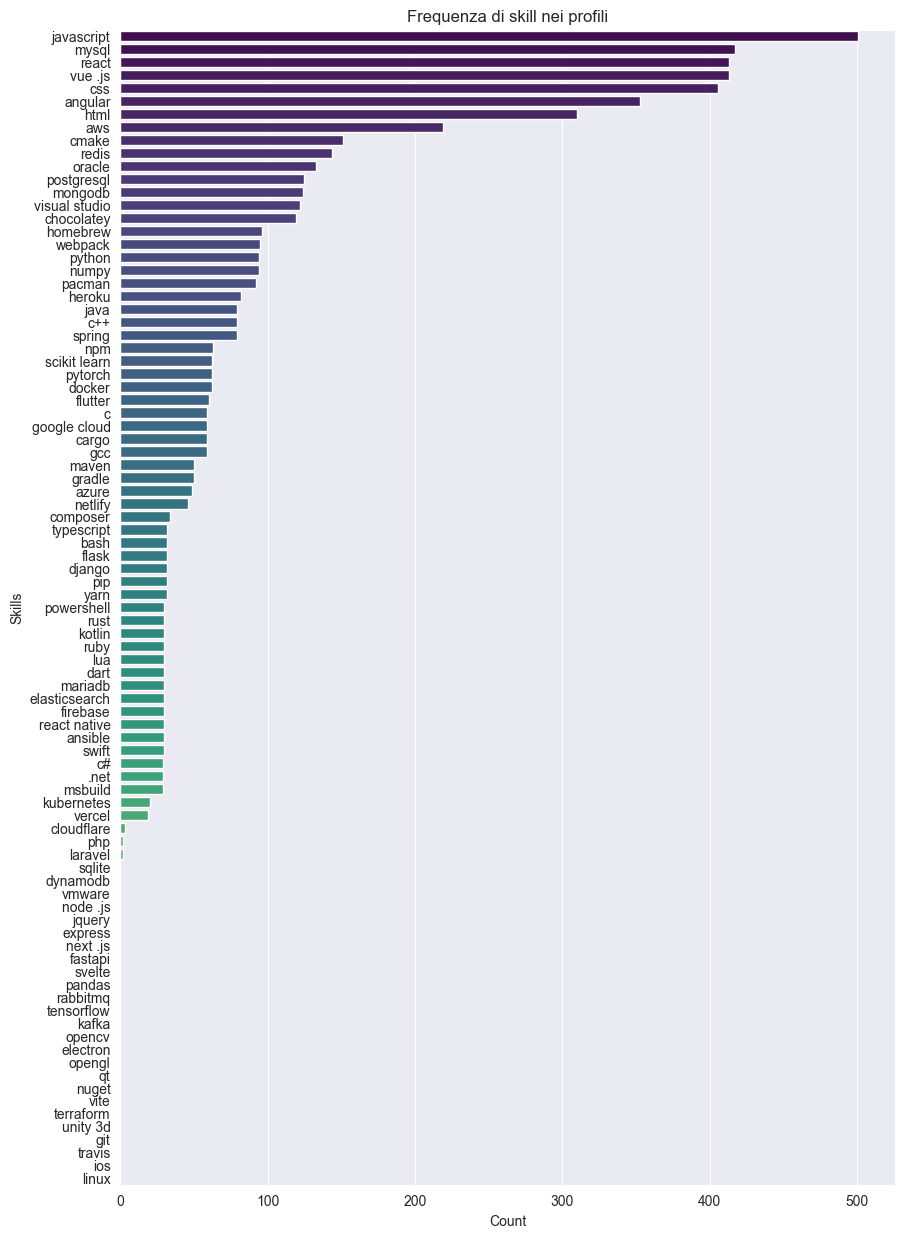

In [5]:
skill_count = Counter()

for skill in skills_list:
    skill_count[skill] = 0

for sset in skills:
    if sset:
        for s in sset:
            skill_count[s] += 1

sorted_counts = {skill: skill_count[skill] for skill in sorted(skill_count, key=skill_count.get, reverse=True)}

plt.figure(figsize=(10, 15))
sns.barplot(x=sorted_counts.values(), y=sorted_counts.keys(), palette='viridis')
plt.title("Frequenza di skill nei profili")
plt.xlabel("Count")
plt.ylabel("Skills")
plt.show()

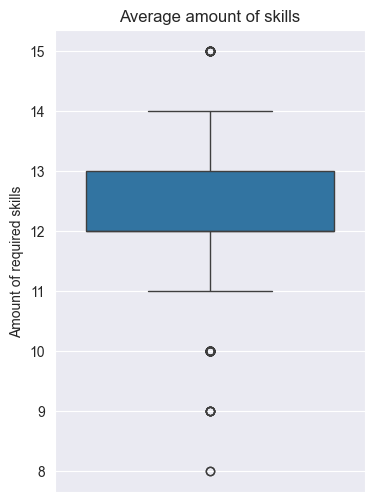

,name,surname,email,password,bio,location,lon,lat,languages,skills
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{angular, react, gradle, mysql, maven, java, c..."
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{redis, docker, react, chocolatey, vue .js, aw..."
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{rust, redis, react, cargo, google cloud, vue ..."
12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{angular, react, mysql, vue .js, mongodb, ruby..."
23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{angular, react, gradle, mysql, maven, java, c..."
...,...,...,...,...,...,...,...,...,...,...
477,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{angular, react, cargo, mysql, gcc, java, spri..."
478,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{angular, ansible, react, mysql, gcc, css, vue..."
492,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{angular, react, gradle, mysql, maven, java, c..."
494,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{angular, react, cargo, mysql, google cloud, g..."


In [6]:
skills_number = []

for sset in skills:
    skills_number.append(len(sset))

plt.figure(figsize=(4, 6))
plt.title("Average amount of skills")
plt.ylabel("Amount of required skills")
sns.boxplot(y=skills_number)
plt.show()

#Extracting outlier values
f = []
for sset in skills:
    f.append(len(sset) > 13 or len(sset) < 10)

outliers = developer_frame.loc[f]
outliers

<h3> Considerazioni </h3>
<p> L'analisi per frequenza delle skill del dataset sintetico mostra alcune criticità </p>
<ul>
    <li> Anzitutto un elevato numero di skills risulta non utilizzato </li>
    <li> Alcune skills hanno monopolizzato la generazione, lasciando altre sottorappresentate, ad esempio: </li>
        <ol>
            <li>Vue.js ha monopolizzato la generazione dei framework.</li>
            <li>MongoDB è sovrarappresentato, rispetto a database popolari come Oracle.</li>
            <li>Tutti gli sviluppatori conoscono almeno una piattaforma cloud, non ncessariamente vero.</li>
            <li>Sono stati generati tool non presenti nel dataset delle competenze.</li>
        </ol>
  </li> 

### Ribilanciamento dei dati
Si è scelto di andare a modificare la frequenza di alcune delle skill presenti nel dataset al fine di farlo aderire di più alla realtà:
In Particolare:
1. Ogni profilo che contiene Vue.js viene ribilanciato per contenere Node.js, jQuery o Express.
2. Ogni profilo che contiene CSS conterrà anche HTML con il 95% della probabilità.
3. Ogni profilo che contiene Redis verrà ribilancaito sostituendolo con Oracle, MySQL e PostgreSQL.
4. Ogni profilo contenente CMAKE verrà ribilanciato inserendo C e C++.
5. Ogni profilo che contiene NumPy verrà ribilanciato inserendo Pandas.
6. Una porzione di profili che contengono React verranno ribilanciati inserendo NextJS.
7. Circa metà dei profili che contengono Python verranno ribilanciati inserendo anche pip.
8. Ogni profilo che contiene Rust verrà ribilanciato inserendo Cargo e viceversa.
9. Circa la metà dei profili che contengono Scikit-Learn verranno ribilanciati inserendo Tensorflow.
10. Verrà aggiunto Git al 90% dei profili.
11. Verrà aggiunto Travis al 25% dei profili che conoscono Git.

In [7]:
rebalance_map = {
    'vue .js' : [(20, 'vue .js'), (30, 'node .js'), (20, 'jquery'), (20, 'express'), (10, 'next .js')],
    'redis' : [(40, 'oracle'), (30, 'mysql'), (20, 'redis'), (10, 'postgresql')],
    'react' : [(80, 'react'), (20, 'next .js')],
    'mongodb':[(50, 'mongodb'), (50, 'sqlite')]
}

imply_map = {
    'javascript': [(5,'svelte'),(10,'electron')],
    'css' : [(100, 'html')],
    'html' : [(100, 'css'),(50,'php')],
    'cmake' : [(100, 'c'), (70, 'c++')],
    'numpy' : [(100, 'pandas'), (50, 'scikit learn')],
    'rust' : [(100, 'cargo')],
    'cargo' : [(100, 'rust')],
    'scikit learn' : [(50, 'tensorflow')],
    'git' : [(10, 'travis')],
    'python' : [(50, 'pip'),(40,'fastapi'),(10,'rabbitmq'),(5,'opencv'),(5,'qt')],
    'pip' : [(100, 'python')],
    'gcc' : [(70, 'c'), (70, 'c++')],
    'java' : [(10,'kafka')],
    'c':[(5,'terraform'), (15,'ios')],
    '.net':[(100,'nuget')],
    'vue .js':[(50,'vite')],
    'react':[(50,'vite')],
    'c++':[(5,'opengl')],
    'c#':[(50,'unity 3d')]
}

add_map = [(80, 'git'), (45, 'python'), (5,'dynamodb'), (5,'cloudflare'),(5,'vmware'),(30,'java'),(30,'linux'),]

In [8]:
def rebalance(skill_set: set) -> set:
    tmp_set = deepcopy(skill_set)
    for skill in skill_set:
        if skill in rebalance_map.keys():
            weights = []
            skills = []
            for weight, s in rebalance_map[skill]:
                weights.append(weight)
                skills.append(s)
            
            new_skill = rng.choices(skills, weights=weights)[0]
            
            if new_skill != skill:
                tmp_set.remove(skill)
                tmp_set.add(new_skill)
    
    return tmp_set

def imply(skill_set: set) -> set:
    added_skills = set()
    for skill in skill_set:
        if skill in imply_map.keys():
            for weight, s in imply_map[skill]:
                if rng.randint(1, 100) <= weight:
                    added_skills.add(s)
    
    return skill_set.union(added_skills)

def add(skill_set: set) -> set:
    tmp_set = deepcopy(skill_set)
    for weight, skill in add_map:
        if rng.randint(1, 100) <= weight:
            tmp_set.add(skill)
    
    skill_set = tmp_set
    return skill_set

In [9]:
skills = developer_frame['skills']
tmp_skills = []
for sset in skills:
    
    sset = add(sset)
    sset = rebalance(sset)
    sset = imply(sset)
    
    tmp_skills.append(sset)

skills = tmp_skills
developer_frame['skills'] = skills
developer_frame

,name,surname,email,password,bio,location,lon,lat,languages,skills
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{angular, oracle, git, react, mysql, webpack, ..."
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{composer, git, django, python, flask, mysql, ..."
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{typescript, angular, yarn, git, node .js, rea..."
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{python, pandas, pytorch, mongodb, postgresql,..."
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{angular, git, css, spring, c++, next .js, kaf..."
...,...,...,...,...,...,...,...,...,...,...
504,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{angular, linux, git, jquery, react, mysql, ve..."
505,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{angular, git, redis, jquery, react, mysql, ne..."
506,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{composer, git, django, python, flask, mysql, ..."
507,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{typescript, angular, yarn, git, node .js, rea..."


C:\Users\anton\AppData\Local\Temp\ipykernel_22740\4258322119.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_counts.values(), y=sorted_counts.keys(), palette='viridis')


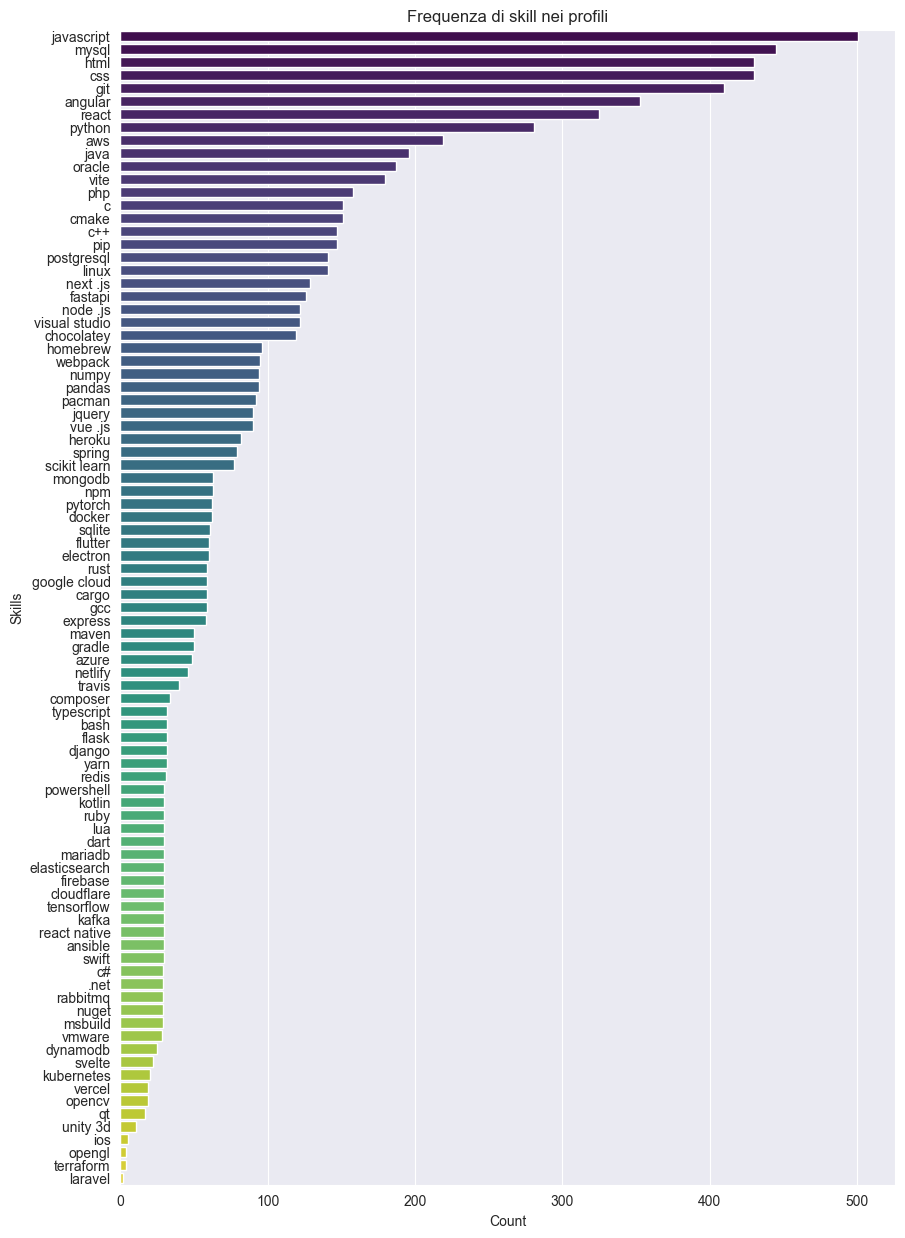

In [10]:
skill_count = Counter()

for skill in skills_list:
    skill_count[skill] = 0

for sset in skills:
    if sset:
        for s in sset:
            skill_count[s] += 1

sorted_counts = {skill: skill_count[skill] for skill in sorted(skill_count, key=skill_count.get, reverse=True)}

plt.figure(figsize=(10, 15))
sns.barplot(x=sorted_counts.values(), y=sorted_counts.keys(), palette='viridis')
plt.title("Frequenza di skill nei profili")
plt.xlabel("Count")
plt.ylabel("Skills")
plt.show()

## Aggiunta valori mancanti :)

In [11]:
languages = {'it_IT': 'italiano', 'en_UK': 'inglese', 'fr_FR' : 'francese', 'es_ES' : 'spagnolo'}
email_suff = ['@gmail.com', '@outlook.com', '@gmail.com', '@yahoo.com']
titles = ['Sig.', 'Sig.ra', 'Dott.', 'Mr.', 'Mr', 'MD', 'Ms', 'Miss']

#Prime 21 città per popolazione per ciascuna lingua mal supportata da faker, fonte Wikipedia
locations = {
    'fr_FR' : (['Paris', 'Marseille', 'Lyon', 'Toulouse', 'Nice', 'Nantes', 'Montpellier',
               'Strasbourg', 'Bordeaux', 'Lille', 'Rennes', 'Reims', 'Toulon', 'Saint-Étienne',
               'Le Havre', 'Grenoble', 'Dijon', 'Angers', 'Saint-Denis', 'Villeurbanne', 'Nimes'],
               'France'),
    'en_UK' : (['London', 'Westminster', 'Birmingham', 'Leeds', 'Glasgow', 'Manchester', 'Sheffield',
               'Bradford', 'Liverpool', 'Bristol', 'Edinburgh', 'Cardiff', 'Leicester', 'Coventry',
               'Wakefield', 'Belfast', 'Nottingham', 'Newcastle upon Tyne', 'Doncaster', 'Milton Keynes'],
               'United Kingdom')
}

faker = Faker(list(languages.keys()))

In [12]:
def generate_name() -> tuple[str, str, str]:
    locales = list(languages.keys())
    
    locale = locales[rng.randint(0, len(locales) - 1)]
    first_raw = faker[locale].first_name()
    last_raw = faker[locale].last_name()
    
    first_clean = ''
    for word in first_raw.split(' '):
        if word not in titles:
            first_clean += ' ' + word
    
    last_clean = ''
    for word in last_raw.split(' '):
        if word not in titles:
            last_clean += ' ' + word
    
    return first_clean, last_clean, locale

In [13]:
dev_info = {
    'name' : [], 
    'surname' : [], 
    'email' : [], 
    'password' : [], 
    'languages' : [],
    'location' : [],
    'lat' : [],
    'lon' : [],
    'bio' : []
}
#len(developer_frame)
to_delete = []
for i in range(0, len(developer_frame)):
    name, surname, locale = generate_name()
    
    email = f'{name.lower()}.{surname.lower()}{email_suff[rng.randint(0, len(email_suff) - 1)]}'.replace(' ', '')
    password = f'{name}{surname}123_'.replace(' ', '') #TODO: hashbrown the passwords :3
    
    langs = set()
    langs.add(languages[locale])
    
    langs = langs.union(set(rng.choices(list(languages.values()), weights=[20, 60, 10, 10], k=rng.randint(0, len(languages) - 1))))
    
    try:
        location = f'{rng.choice(locations[locale][0])}, {locations[locale][1]}'
    except KeyError:
        location = f'{faker[locale].city()}, {faker[locale].current_country()}'
    
    try:
        lat, lon = get_coordinates(location).values()
    except Exception:
        print(location, i)
        to_delete.append(i)
        
    
    dev_info['name'].append(name)
    dev_info['surname'].append(surname)
    dev_info['email'].append(email)
    dev_info['password'].append(password)
    dev_info['languages'].append(langs)
    dev_info['location'].append(location)
    dev_info['lat'].append(lat)
    dev_info['lon'].append(lon)
    dev_info['bio'].append('This is an automatically generated profile for testing purposes.')

developer_frame.loc[:, 'name'] = dev_info['name']
developer_frame.loc[:, 'surname'] = dev_info['surname']
developer_frame.loc[:, 'email'] = dev_info['email']
developer_frame.loc[:, 'password'] = dev_info['password']
developer_frame.loc[:, 'languages'] = dev_info['languages']
developer_frame.loc[:, 'location'] = dev_info['location']
developer_frame.loc[:, 'lat'] = dev_info['lat']
developer_frame.loc[:, 'lon'] = dev_info['lon']
developer_frame.loc[:, 'bio'] = dev_info['bio'] 

developer_frame.drop(to_delete)

developer_frame 

,name,surname,email,password,bio,location,lon,lat,languages,skills
0,Enzo,Brugnaro,enzo.brugnaro@outlook.com,EnzoBrugnaro123_,This is an automatically generated profile for...,"Millepini, Italy",11.784508,45.319027,"{inglese, spagnolo, italiano}","{angular, oracle, git, react, mysql, webpack, ..."
1,Pepito,Ureña,pepito.ureña@gmail.com,PepitoUreña123_,This is an automatically generated profile for...,"Murcia, Spain",-1.130654,37.99224,"{francese, spagnolo}","{composer, git, django, python, flask, mysql, ..."
2,Eugenio,Bernal,eugenio.bernal@yahoo.com,EugenioBernal123_,This is an automatically generated profile for...,"Guipúzcoa, Spain",-2.223667,43.07563,"{francese, spagnolo}","{typescript, angular, yarn, git, node .js, rea..."
3,Marcus,Reed,marcus.reed@gmail.com,MarcusReed123_,This is an automatically generated profile for...,"Edinburgh, United Kingdom",-3.188267,55.953252,{inglese},"{python, pandas, pytorch, mongodb, postgresql,..."
4,Luc,Paul,luc.paul@gmail.com,LucPaul123_,This is an automatically generated profile for...,"Toulouse, France",1.444209,43.604652,"{inglese, francese, spagnolo}","{angular, git, css, spring, c++, next .js, kaf..."
...,...,...,...,...,...,...,...,...,...,...
504,Agostino,Spadafora,agostino.spadafora@gmail.com,AgostinoSpadafora123_,This is an automatically generated profile for...,"Ravi, Italy",10.918927,42.91084,"{inglese, italiano}","{angular, linux, git, jquery, react, mysql, ve..."
505,Tina,Fusani,tina.fusani@gmail.com,TinaFusani123_,This is an automatically generated profile for...,"Kaltern, Italy",11.240259,46.412975,"{inglese, italiano}","{angular, git, redis, jquery, react, mysql, ne..."
506,Mario,Posada,mario.posada@gmail.com,MarioPosada123_,This is an automatically generated profile for...,"Jaén, Spain",-3.784906,37.779594,"{inglese, spagnolo}","{composer, git, django, python, flask, mysql, ..."
507,Shirley,Swift,shirley.swift@yahoo.com,ShirleySwift123_,This is an automatically generated profile for...,"Milton Keynes, United Kingdom",-0.759417,52.040622,{inglese},"{typescript, angular, yarn, git, node .js, rea..."


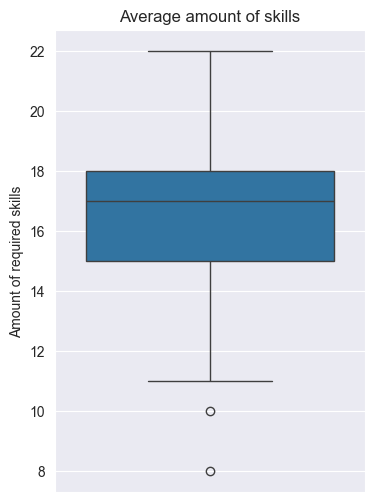

,name,surname,email,password,bio,location,lon,lat,languages,skills
8,Marie,Roux,marie.roux@outlook.com,MarieRoux123_,This is an automatically generated profile for...,"Montpellier, France",3.876716,43.610769,"{francese, italiano}","{git, chocolatey, postgresql, aws, mariadb, do..."
98,Margaux,Samson,margaux.samson@gmail.com,MargauxSamson123_,This is an automatically generated profile for...,"Reims, France",4.031696,49.258329,"{inglese, francese}","{git, redis, jquery, react, chocolatey, vite, ..."


In [14]:
skills_number = []

for sset in skills:
    skills_number.append(len(sset))

plt.figure(figsize=(4, 6))
plt.title("Average amount of skills")
plt.ylabel("Amount of required skills")
sns.boxplot(y=skills_number)
plt.show()

f = []

for sset in skills:
    f.append(len(sset) < 11 or len(sset) > 22)

outliers = developer_frame.loc[f]
outliers

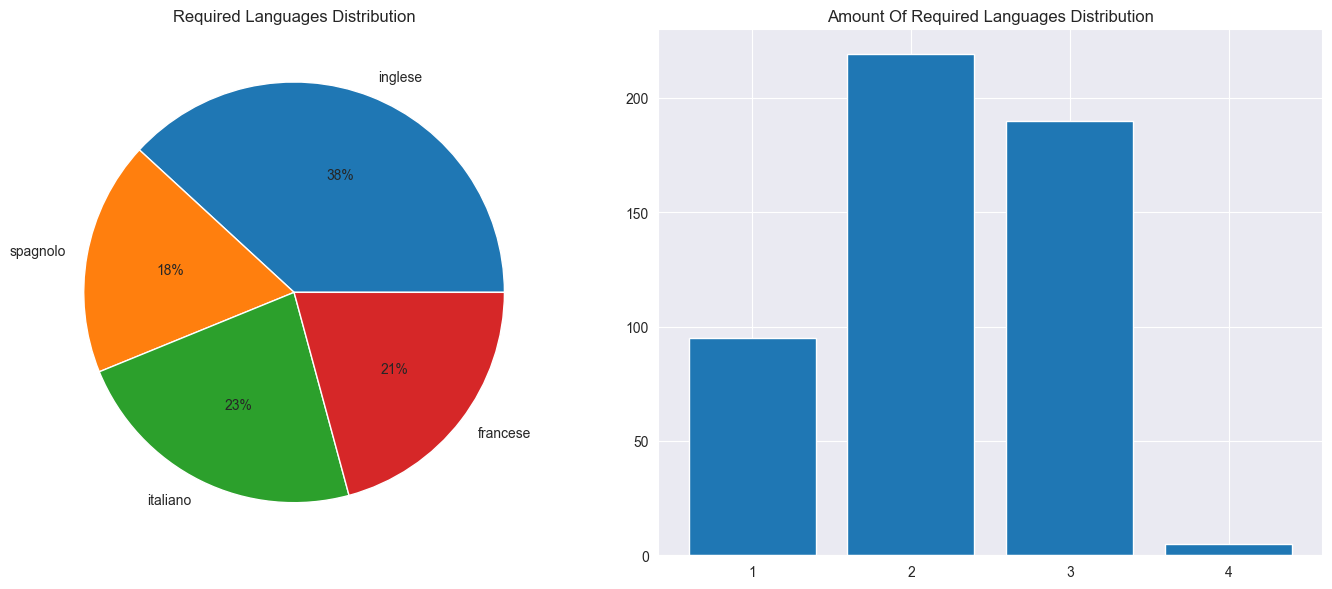

In [15]:
# The count is executed given the assumption that the Required Languages can be Italian or English
language_counter = Counter()
language_number_counter = Counter()
for offer_languages in developer_frame.loc[:, 'languages']:
    for l in set(offer_languages):
        language_counter[l] += 1
            
    language_number_counter[len(offer_languages)] += 1
    
# Pie chart for Required Languages Distribution
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.title('Required Languages Distribution')
plt.pie(language_counter.values(), labels=language_counter.keys(), autopct='%0.f%%')

# Bar chart for Amount Of Required Languages Distribution
plt.subplot(1, 2, 2)
plt.title('Amount Of Required Languages Distribution')
plt.bar(['1', '2', '3', '4'], language_number_counter.values())

plt.tight_layout()  # To prevent overlapping of subplots
plt.show()

In [16]:
from commons import translate_skills

#Conversion from skill as strings to ids

skill_ids = []
for sset in skills:
    skill_ids.append(translate_skills(sset, skills_frame, to_id=True))
developer_frame.loc[:, 'skills'] = skill_ids
developer_frame

,name,surname,email,password,bio,location,lon,lat,languages,skills
0,Enzo,Brugnaro,enzo.brugnaro@outlook.com,EnzoBrugnaro123_,This is an automatically generated profile for...,"Millepini, Italy",11.784508,45.319027,"{inglese, spagnolo, italiano}","{0, 1, 99, 100, 36, 39, 41, 74, 44, 78, 47, 19..."
1,Pepito,Ureña,pepito.ureña@gmail.com,PepitoUreña123_,This is an automatically generated profile for...,"Murcia, Spain",-1.130654,37.99224,"{francese, spagnolo}","{0, 2, 100, 75, 76, 50, 19, 52, 21, 58, 59, 93..."
2,Eugenio,Bernal,eugenio.bernal@yahoo.com,EugenioBernal123_,This is an automatically generated profile for...,"Guipúzcoa, Spain",-2.223667,43.07563,"{francese, spagnolo}","{32, 1, 0, 99, 100, 4, 40, 41, 9, 8, 44, 77, 7..."
3,Marcus,Reed,marcus.reed@gmail.com,MarcusReed123_,This is an automatically generated profile for...,"Edinburgh, United Kingdom",-3.188267,55.953252,{inglese},"{64, 97, 2, 67, 5, 27, 73, 76, 18, 21, 58, 59,..."
4,Luc,Paul,luc.paul@gmail.com,LucPaul123_,This is an automatically generated profile for...,"Toulouse, France",1.444209,43.604652,"{inglese, francese, spagnolo}","{0, 1, 6, 8, 19, 26, 31, 43, 44, 45, 56, 61, 6..."
...,...,...,...,...,...,...,...,...,...,...
504,Agostino,Spadafora,agostino.spadafora@gmail.com,AgostinoSpadafora123_,This is an automatically generated profile for...,"Ravi, Italy",10.918927,42.91084,"{inglese, italiano}","{0, 1, 99, 100, 37, 104, 41, 42, 74, 44, 78, 1..."
505,Tina,Fusani,tina.fusani@gmail.com,TinaFusani123_,This is an automatically generated profile for...,"Kaltern, Italy",11.240259,46.412975,"{inglese, italiano}","{0, 1, 99, 100, 38, 41, 42, 74, 44, 78, 19, 85..."
506,Mario,Posada,mario.posada@gmail.com,MarioPosada123_,This is an automatically generated profile for...,"Jaén, Spain",-3.784906,37.779594,"{inglese, spagnolo}","{0, 1, 2, 99, 100, 6, 75, 76, 50, 19, 52, 21, ..."
507,Shirley,Swift,shirley.swift@yahoo.com,ShirleySwift123_,This is an automatically generated profile for...,"Milton Keynes, United Kingdom",-0.759417,52.040622,{inglese},"{0, 1, 99, 100, 4, 40, 41, 9, 8, 44, 77, 78, 1..."


# Export

In [17]:
def set_to_string(item_set):
    return ', '.join(map(str, item_set))

developer_frame['skills'] = developer_frame['skills'].apply(set_to_string)
developer_frame['languages'] = developer_frame['languages'].apply(set_to_string)

with sqlite3.connect('../datasets/developers_dataset.db') as export_conn:
    export_curs = export_conn.cursor()
    export_conn.execute('DROP TABLE IF EXISTS developers')
    export_conn.execute(
        '''
        CREATE TABLE IF NOT EXISTS developers (
            name TEXT,
            surname TEXT,
            location TEXT,
            Skills TEXT,
            bio TEXT,
            email TEXT,
            password TEXT,
            Languages TEXT,
            Lat REAL,
            Lon REAL
        )
        '''
    )
    
    export_conn.commit()
    
    developer_frame.to_sql('developers', con=export_conn, if_exists='append', index=False)
    
    export_conn.commit()